# UCI HAR - classification
- https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

#### 데이터 종류
- 561개 특성으로 전처리된 메인 데이터셋(X_train, X_test)
- Inertial Signals 데이터셋: 원시 센서 값(raw signal)

#### Inertial Signals 데이터 구조
- 각 파일은 행 = 샘플(segment), 열 = 시계열 프레임을 의미
- 각 샘플은 2.56초 길이 (샘플링 주파수 50Hz, 128 타임스텝 → 128 / 50 = 2.56초)
- 이미 샘플링이 되어 있으므로(7352개의 샘플) split_sequence() 사용하지 않아도 됨
- 한 행이 (128,) 길이의 시계열 벡터
- 세 축(X, Y, Z)와 센서 종류(acc, gyro)로 분리되어 있음

#### 센서 및 값의 의미
- Total acceleration (total_acc): 스마트폰 가속도계로 측정한 총 가속도 (중력 + 신체 움직임 포함)
- Body acceleration (body_acc): 총 가속도에서 중력 성분을 제거한 값 (실제 동작 가속도)
- Gyroscope (body_gyro): 각속도(회전 속도), 단위는 rad/sec, 스마트폰의 자이로스코프 센서 값

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv1D, BatchNormalization, ReLU, MaxPool1D, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

In [ ]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_data/UCI_HAR_Dataset/UCI HAR Dataset/"

# Load "X"
def load_X(X_signals_paths):
    X_signals = []

    for signal_type_path in X_signals_paths:
        series_list = []  # 한 센서축 데이터 전체 저장

        with open(signal_type_path, 'r') as file:
            for row in file:
                row_clean = row.replace('  ', ' ') # 공백 2개를 1개로
                row_clean = row_clean.strip() # 양쪽 공백 제거
                serie = row_clean.split(' ') # 공백 기준 split
                serie_array = np.array(serie, dtype=np.float32) # float32 numpy 배열로 변환
                series_list.append(serie_array) # 시퀀스 추가

        # 하나의 센서축 데이터 추가 (feature)
        X_signals.append(series_list)

    # shape: (특성 수, 샘플 수, 타임스텝 수)
    X_signals = np.array(X_signals)
    # shape 변환 → (샘플 수, 타임스텝 수, 특성 수)
    return np.transpose(X_signals, (1, 2, 0))


X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt"
    for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt"
    for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (7352, 128, 9)
X_test shape: (2947, 128, 9)


In [ ]:
# Load "y"

def load_y(y_path):
    with open(y_path, 'r') as file:
        labels = [int(line.strip()) for line in file]
    # 라벨을 0부터 시작하도록 -1 (원래 라벨이 1부터 시)
    return np.array(labels, dtype=np.int32) - 1


y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (7352,)
y_test shape: (2947,)


In [ ]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis] # 각 시퀀스 위치 pos 벡터
    depths = np.arange(depth)[np.newaxis, :]/depth # /depth로 정규화,
    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates # broadcasting
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = int(embed_dim)
        self.num_heads = int(num_heads)
        self.ff_dim = int(ff_dim)
        self.rate = float(rate)

        self.att = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads
        )
        self.ffn = Sequential([
            Dense(self.ff_dim, activation="relu"),
            Dense(self.embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(self.rate)
        self.dropout2 = Dropout(self.rate)

    def call(self, inputs, training=None):
        attn = self.att(inputs, inputs, training=training)
        x1 = self.layernorm1(inputs + self.dropout1(attn, training=training))
        ffn = self.ffn(x1, training=training)
        return self.layernorm2(x1 + self.dropout2(ffn, training=training))

## Model 1
- CNN 2, GRU 1, Transformer 1
- Conv1D 출력과 TransformerBlock의 embed_dim 수가 일치해야함
- residual addition 할 때 shape이 맞아야 하기 때문

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 469,766 (1.79 MB)

 Trainable params: 468,998 (1.79 MB)

 Non-trainable params: 768 (3.00 KB)

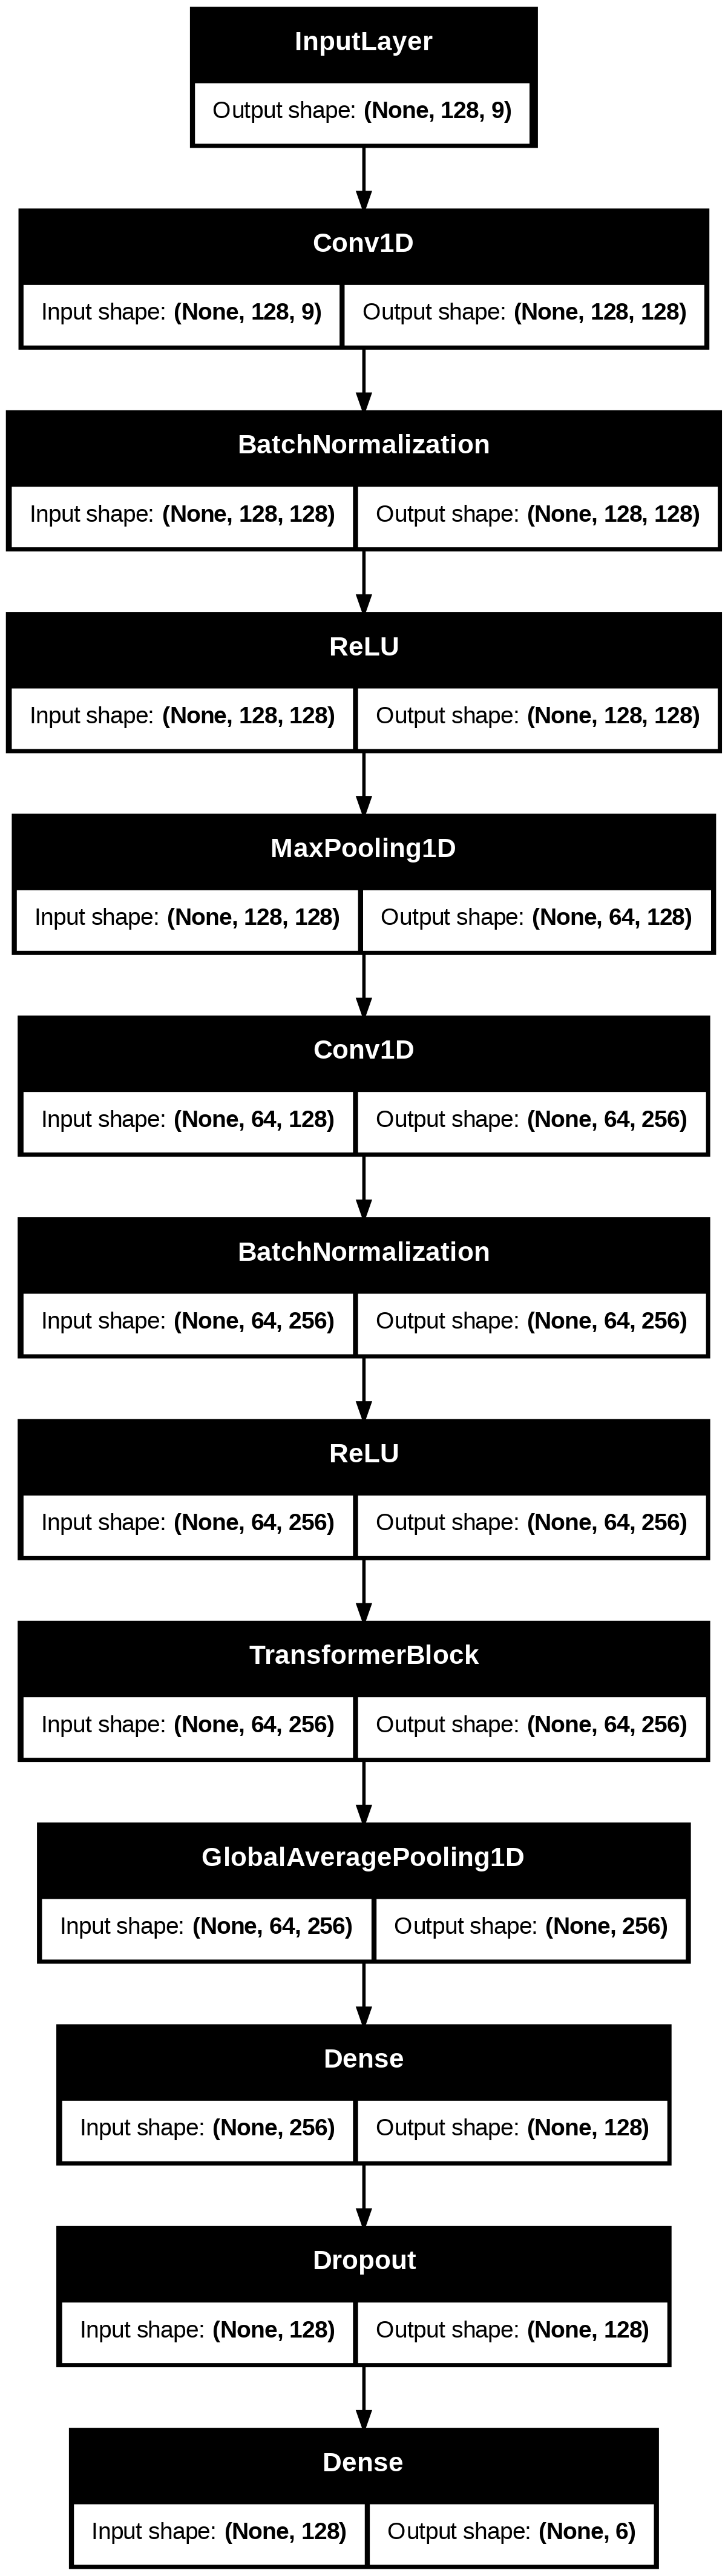

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_Transformer_best.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.4916 - sparse_categorical_accuracy: 0.7949
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.27532, saving model to UCI_HAR_CNN_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - loss: 0.4895 - sparse_categorical_accuracy: 0.7959 - val_loss: 5.0060 - val_sparse_categorical_accuracy: 0.2753
Epoch 2/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1294 - sparse_categorical_accuracy: 0.9438
Epoch 2: val_sparse_categorical_accuracy improved from 0.27532 to 0.31611, saving model to UCI_HAR_CNN_Transformer_best.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9440 - val_loss: 4.4007 - val_sparse_categorical_accuracy: 0.3161
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1483 - sparse_categorical_accuracy: 0.9328
Epoch 3: val_sparse_categorical_accuracy improved from 0.31611 to 0.82121, saving model to UCI_HAR_CNN_Transformer_be

In [ ]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("UCI_HAR_CNN_GRU_Transformer_best.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 97.55%
Training loss: 0.0938
Test accuracy: 93.52%
Test loss: 0.3976


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9811    0.9395    0.9598       496
           1     0.9932    0.9363    0.9639       471
           2     0.8811    0.9881    0.9315       420
           3     0.9176    0.8167    0.8642       491
           4     0.8581    0.9323    0.8937       532
           5     0.9908    1.0000    0.9954       537

    accuracy                         0.9352      2947
   macro avg     0.9370    0.9355    0.9348      2947
weighted avg     0.9378    0.9352    0.9351      2947



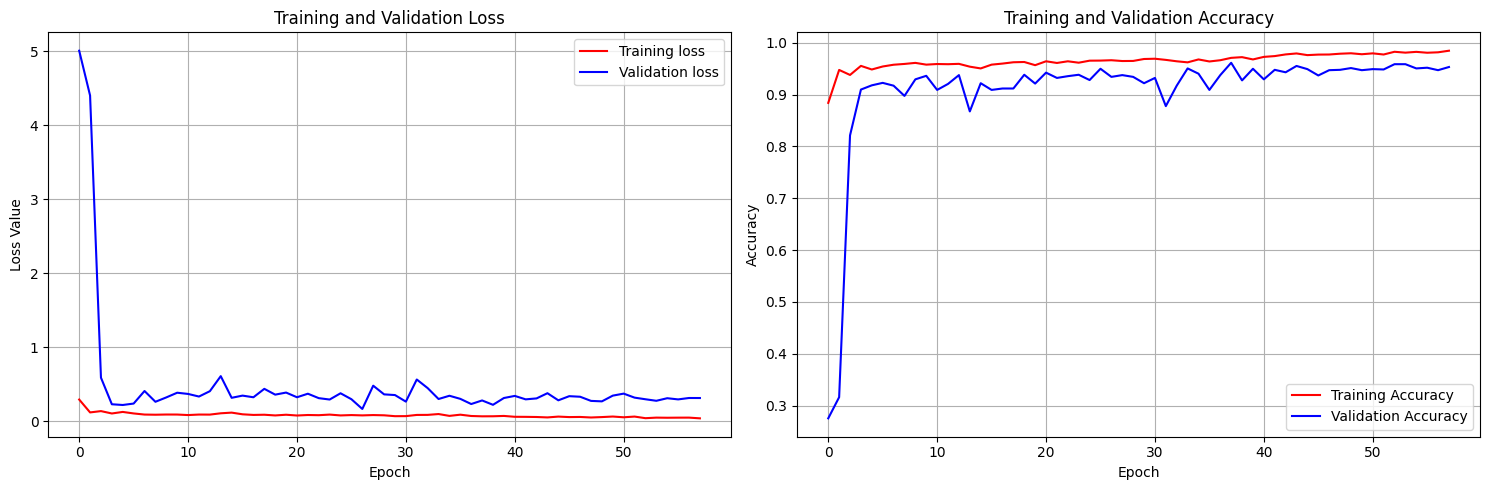

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

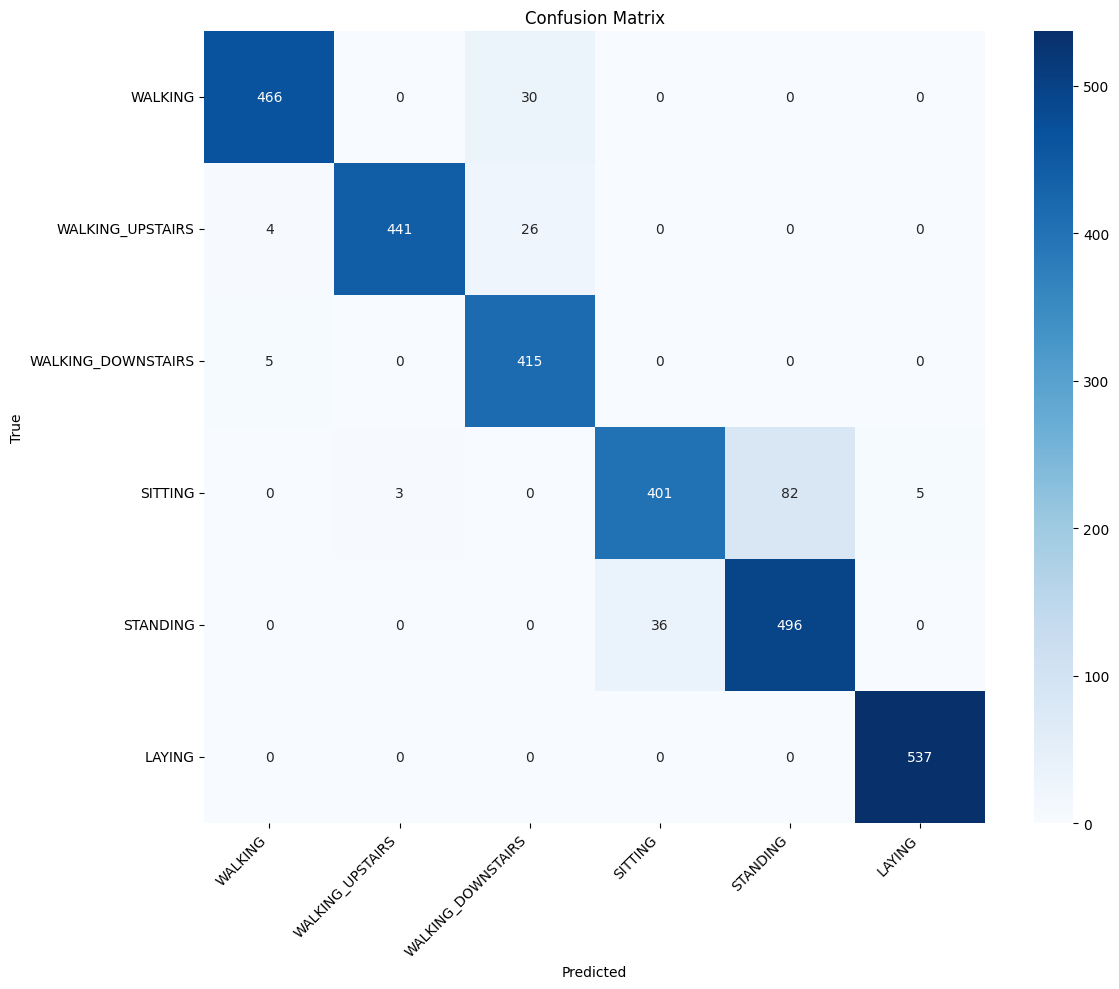

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 2
- CNN 2, GRU 2, Transformer 1

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 128, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,558 (1.98 MB)

 Trainable params: 518,534 (1.98 MB)

 Non-trainable params: 1,024 (4.00 KB)

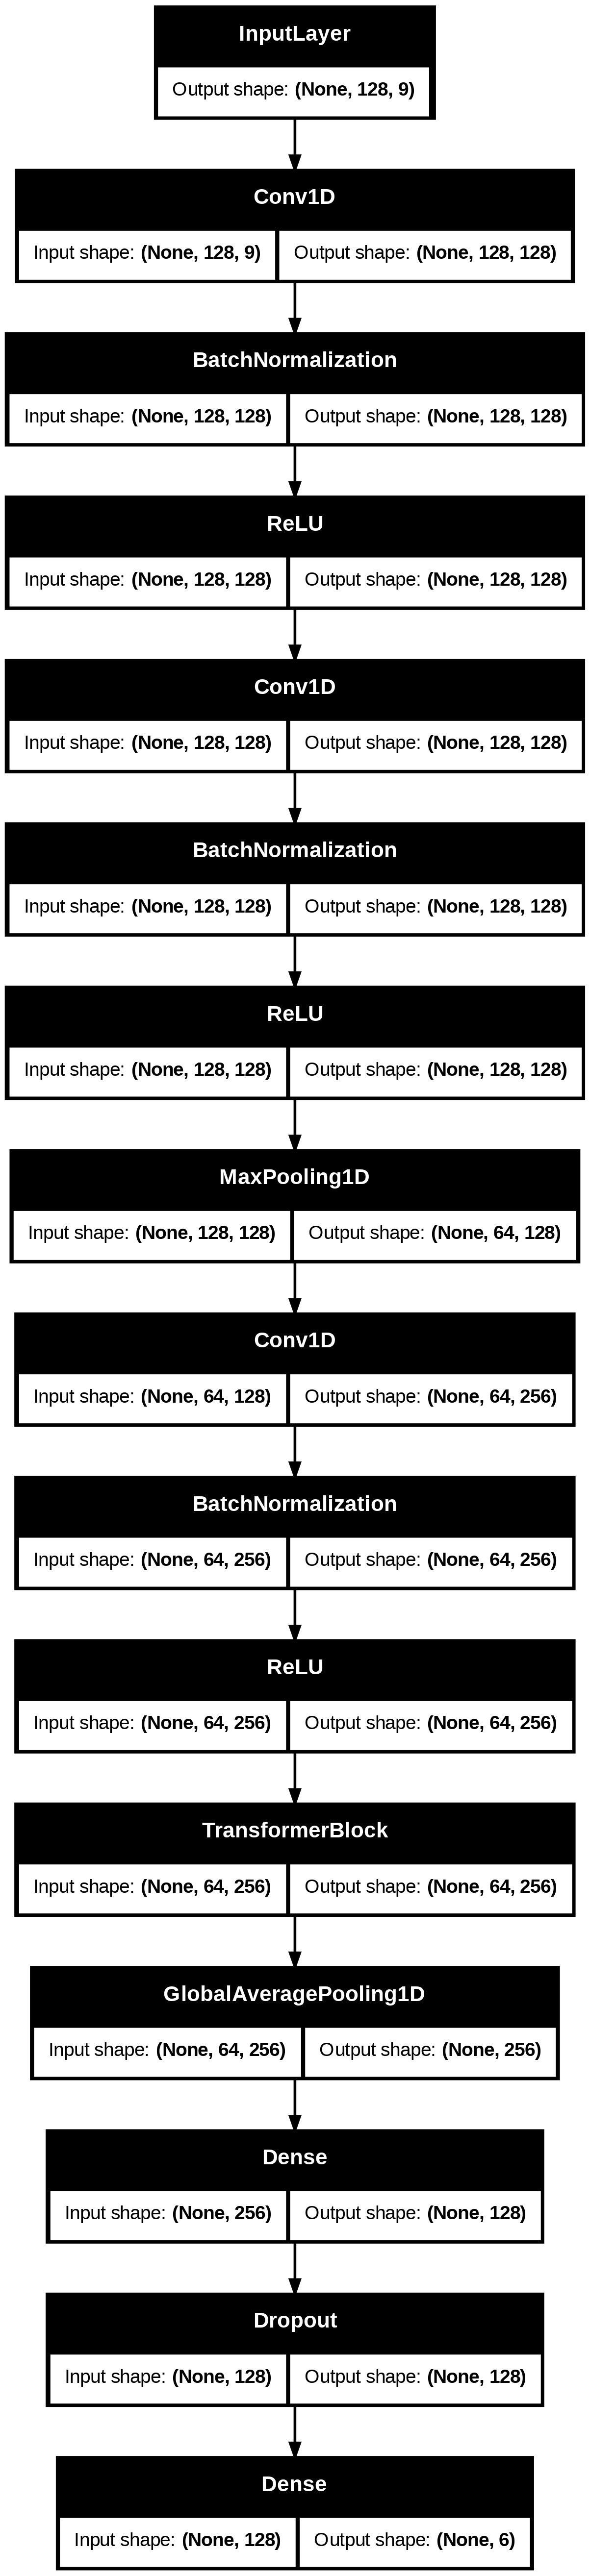

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_Transformer_best2.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.5135 - sparse_categorical_accuracy: 0.8013
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.28484, saving model to UCI_HAR_CNN_Transformer_best2.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - loss: 0.5110 - sparse_categorical_accuracy: 0.8023 - val_loss: 4.8042 - val_sparse_categorical_accuracy: 0.2848
Epoch 2/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1238 - sparse_categorical_accuracy: 0.9480
Epoch 2: val_sparse_categorical_accuracy improved from 0.28484 to 0.30727, saving model to UCI_HAR_CNN_Transformer_best2.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9480 - val_loss: 3.5147 - val_sparse_categorical_accuracy: 0.3073
Epoch 3/100
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.9458
Epoch 3: val_sparse_categorical_accuracy improved from 0.30727 to 0.67029, saving model to UCI_HAR_CNN_Transform

In [ ]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("UCI_HAR_CNN_GRU_Transformer_best2.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 98.88%
Training loss: 0.0780
Test accuracy: 92.81%
Test loss: 0.6683


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8468    0.9170       496
           1     0.9844    0.9363    0.9597       471
           2     0.8092    1.0000    0.8946       420
           3     0.9548    0.8167    0.8804       491
           4     0.8571    0.9699    0.9101       532
           5     0.9981    1.0000    0.9991       537

    accuracy                         0.9281      2947
   macro avg     0.9339    0.9283    0.9268      2947
weighted avg     0.9367    0.9281    0.9282      2947



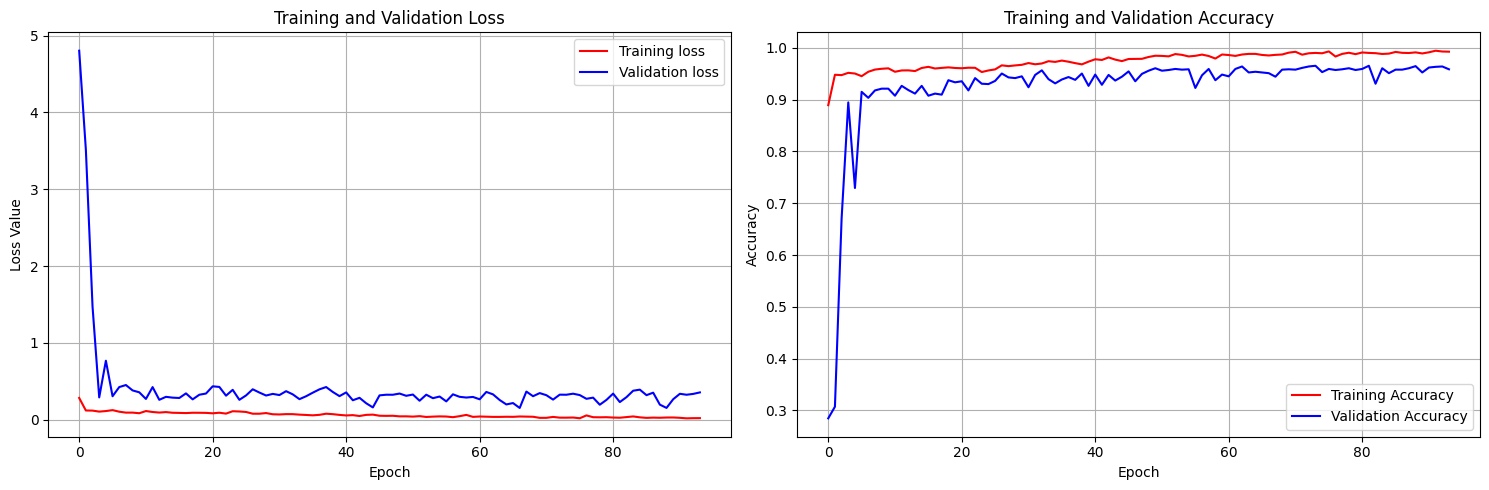

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

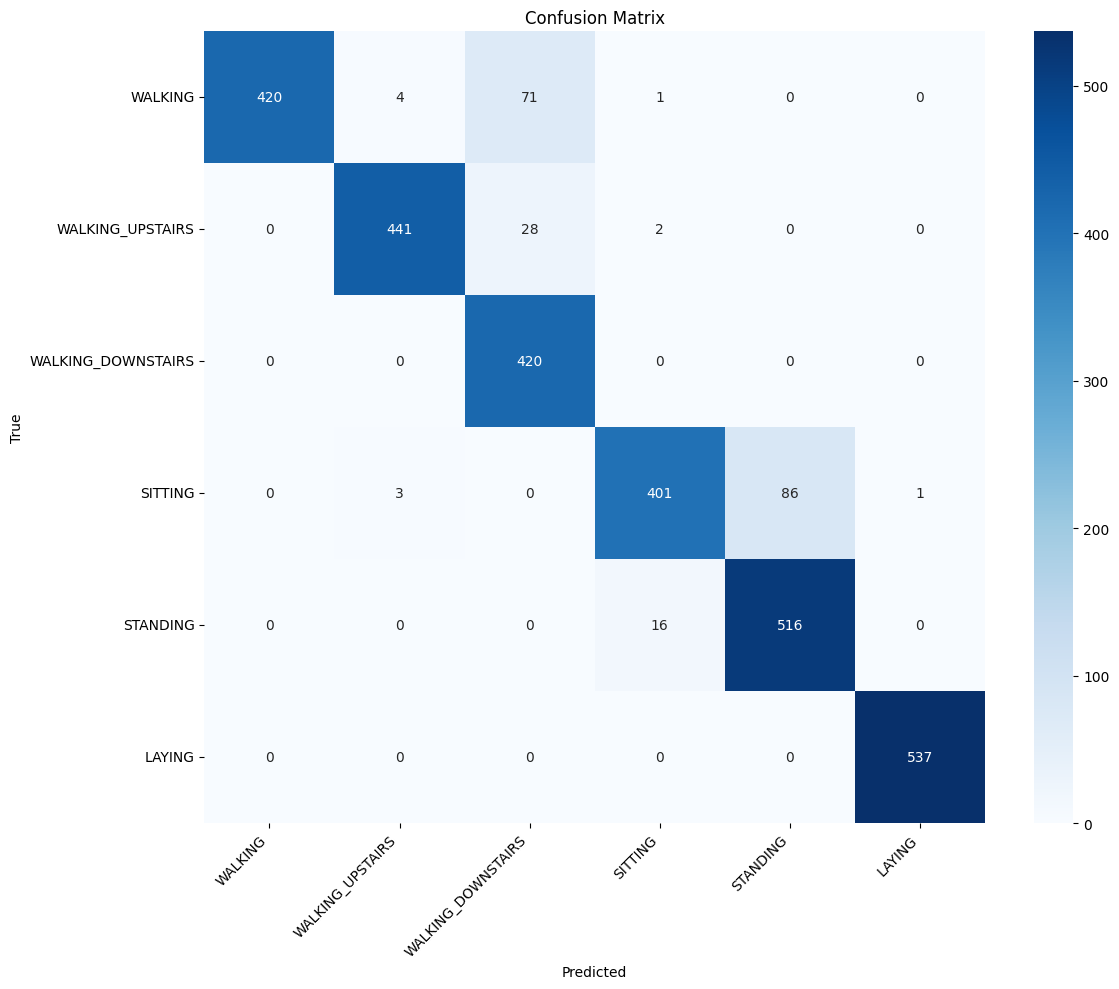

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()

## Model 3
- CNN 3, GRU 2, Transformer 1

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, features)
num_classes = 6

def build_model(input_shape, num_classes=6):
    inputs = Input(shape=input_shape)

    # CNN 특징 추출 레이어
    x = Conv1D(128, 5, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(128, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool1D(2)(x)

    x = Conv1D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GRU(256, return_sequences=True)(x)
    x = GRU(256, return_sequences=True)(x)

    x = TransformerBlock(embed_dim=256, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy']
    )
    return model

model = build_model(input_shape, num_classes)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 128, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_15 (ReLU)                 │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 64, 256)        │       330,112 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_5      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849,670 (3.24 MB)

 Trainable params: 848,646 (3.24 MB)

 Non-trainable params: 1,024 (4.00 KB)

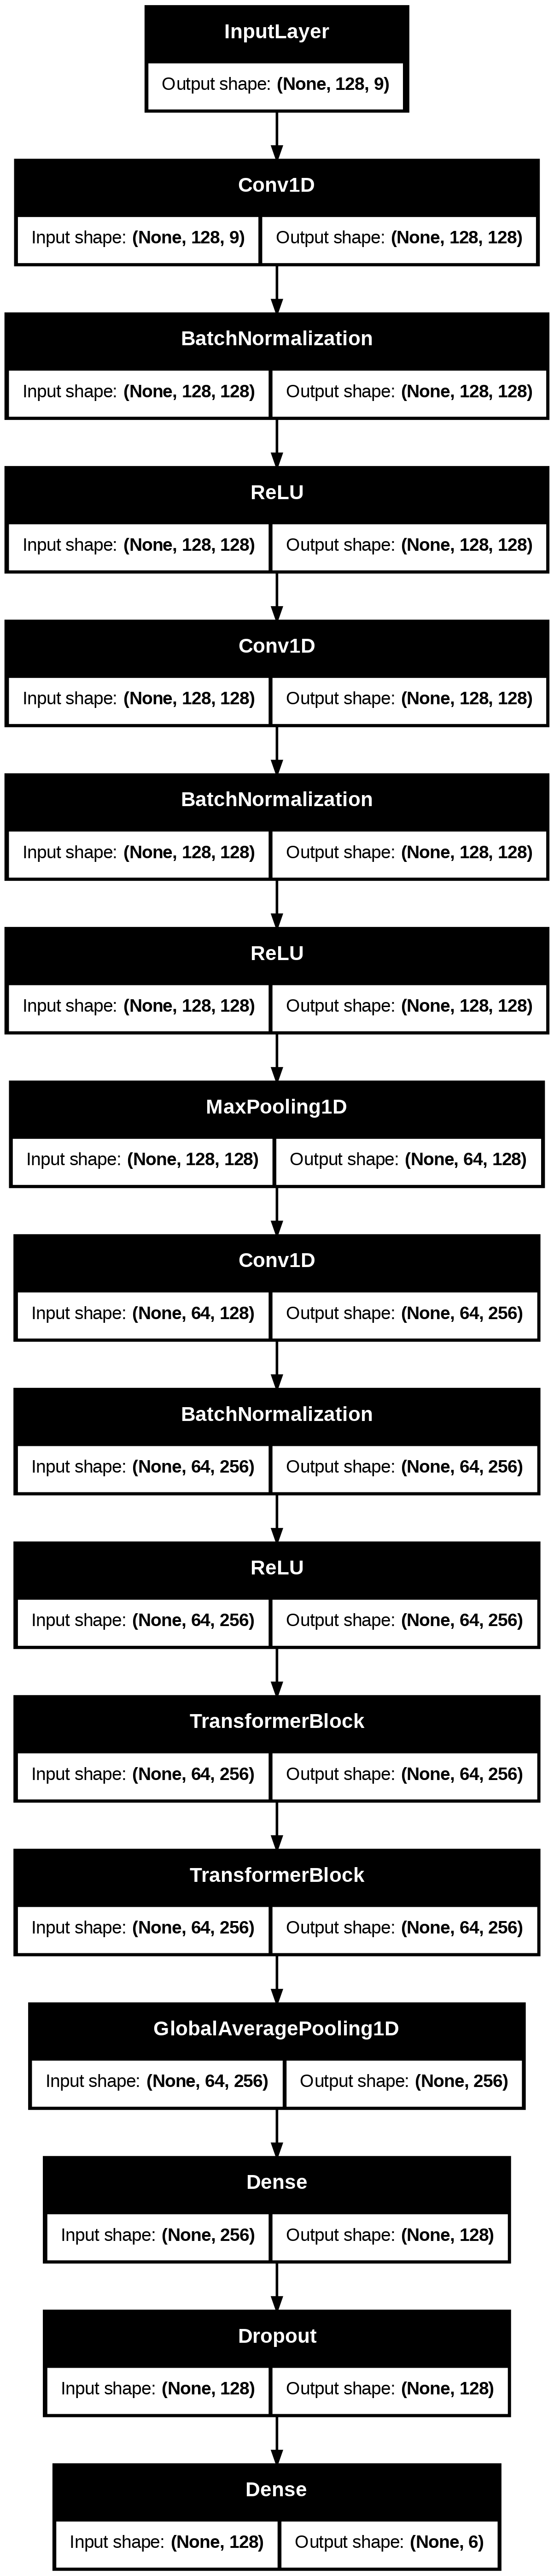

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "UCI_HAR_CNN_GRU_Transformer_best3.weights.h5",
                save_best_only=True,
                save_weights_only=True,
                monitor="val_sparse_categorical_accuracy",
                mode='max',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_sparse_categorical_accuracy",
                patience=20,
                verbose=1,
                mode='max',
                restore_best_weights=True
            )
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.5405 - sparse_categorical_accuracy: 0.7854
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.24133, saving model to UCI_HAR_CNN_Transformer_best3.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - loss: 0.5379 - sparse_categorical_accuracy: 0.7865 - val_loss: 6.2246 - val_sparse_categorical_accuracy: 0.2413
Epoch 2/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9492
Epoch 2: val_sparse_categorical_accuracy improved from 0.24133 to 0.26581, saving model to UCI_HAR_CNN_Transformer_best3.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.1218 - sparse_categorical_accuracy: 0.9492 - val_loss: 5.4013 - val_sparse_categorical_accuracy: 0.2658
Epoch 3/100
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1184 - sparse_categorical_accuracy: 0.9479
Epoch 3: val_sparse_categorical_accuracy improved from 0.26581 to 0.70836, saving model to UCI_HAR_CNN_Transform

In [ ]:
# 모델 평가
model = build_model(input_shape, num_classes)
model.load_weights("UCI_HAR_CNN_GRU_Transformer_best3.weights.h5")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Training accuracy: 96.12%
Training loss: 0.1134
Test accuracy: 93.35%
Test loss: 0.2276


In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9713    0.9536    0.9624       496
           1     0.9354    0.9533    0.9443       471
           2     0.9142    0.9643    0.9386       420
           3     0.8894    0.8350    0.8613       491
           4     0.8933    0.8966    0.8949       532
           5     0.9908    1.0000    0.9954       537

    accuracy                         0.9335      2947
   macro avg     0.9324    0.9338    0.9328      2947
weighted avg     0.9332    0.9335    0.9331      2947



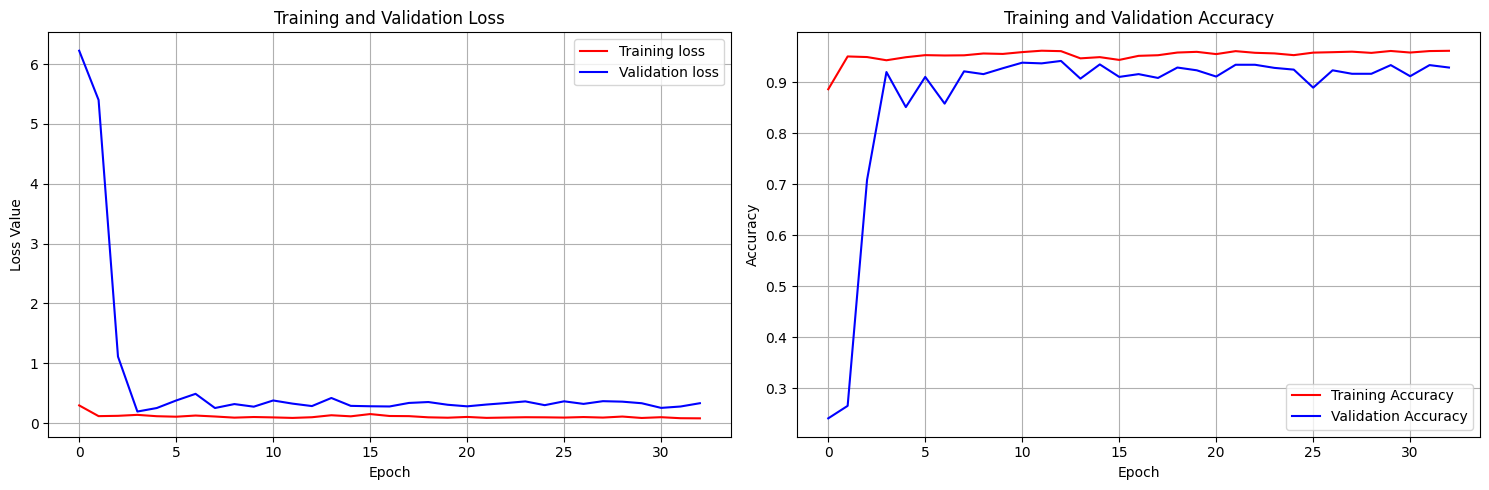

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

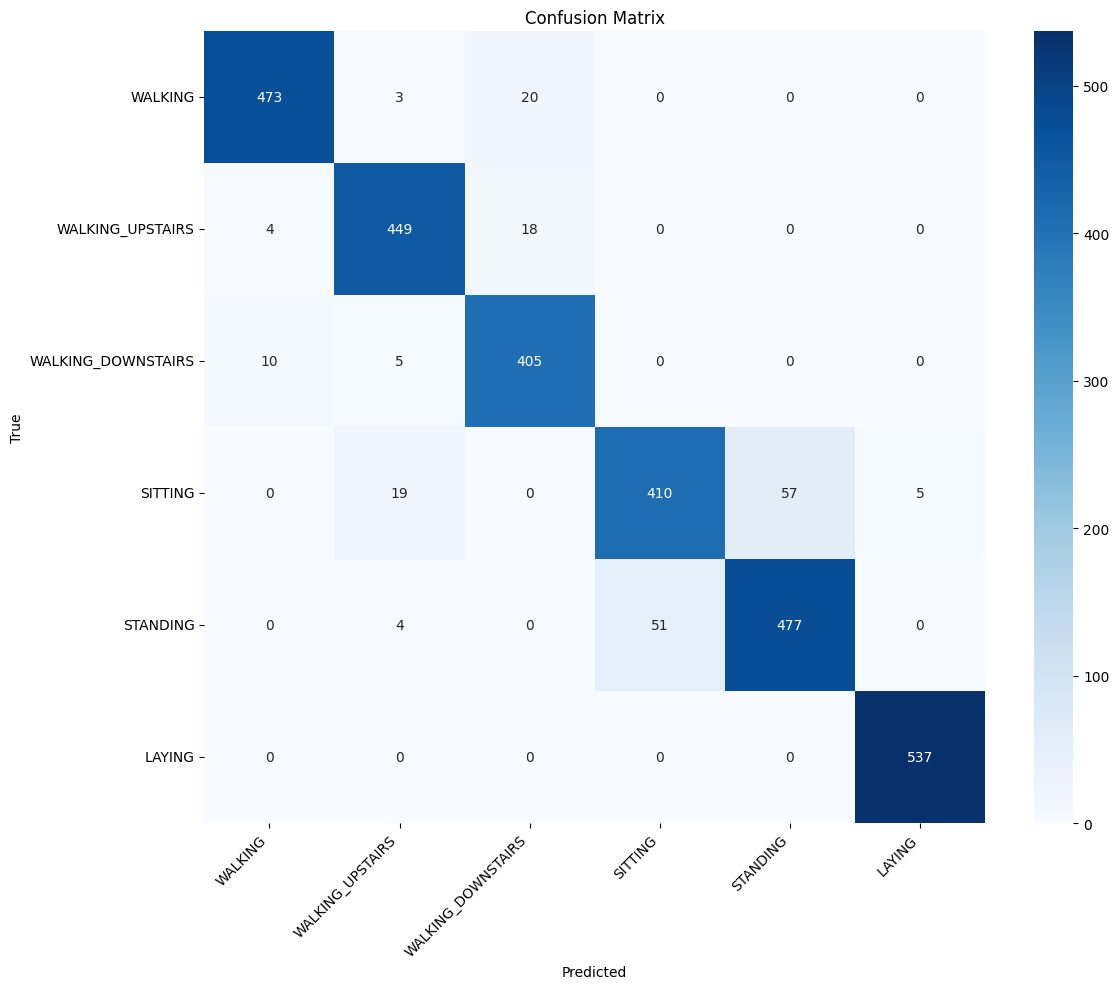

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

n_classes = len(np.unique(y_test))
if n_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:n_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:n_classes], rotation=0)

plt.tight_layout()
plt.show()